# LLM Deployment and RAG Setup Guide

## Overview
This guide details the deployment of the LLM using Docker, along with the integration of retrieval-augmented generation (RAG) tools.

Prequisities for the demo 

1. Docker Installation


## LLM Deployment
Deploying the LLM Inference using the Text Generation Inference [TGI](https://github.com/huggingface/tgi-gaudi) using Docker.

1. Replace the hf_token with the real Hugging face API token
2. HABANA_VISIBLE_DEVICES=all, Update the device ids accordingly if multiple applications are running on a single node.
3. Currently Mistral instruct v0.3 is being used. model-id value can be updated to use other models.
4. Update the num-shard to the count of Gaudi devices being used to deploy LLM.

In [ ]:
docker run -d --runtime=habana --name "comps-tgi-gaudi-service" \
  -p 9009:80 -v ./data:/data \
  -e HF_TOKEN=hf_token \
  -e HABANA_VISIBLE_DEVICES=all \
  -e PT_HPU_ENABLE_LAZY_COLLECTIVES=true \
  -e OMPI_MCA_btl_vader_single_copy_mechanism=none \
  --cap-add=sys_nice --ipc=host \
  ghcr.io/huggingface/tgi-gaudi:2.0.4 \
  --model-id <model name> \
  --sharded true --num-shard <num_shards> --max-input-tokens 8092 --max-total-tokens 16184

## Agent Workflow Overview
- **Web Search Tool**: Utilize the out-of-the-box web search tool provided by Langchain.
- **RAG Retrieval Tool**: Implement the RAG retrieval tool from OPEA. All components run on Xeon, leveraging all eight cards for the LLM model.
  - Repository: [OPEA GenAIExamples](https://github.com/opea-project/GenAIExamples)
- **RAG Agent**: Use the `langchain_strategy` for the RAG agent implementation.

### RAG Tool Setup

In [ ]:
# Clone the repository
git clone https://github.com/opea-project/GenAIExamples.git

# Navigate to the Docker Compose Directory
cd GenAIExamples/DocIndexRetriever/docker_compose/intel/cpu/xeon

# Build the Custom Retrieval image
cd GenAIExamples/DocIndexRetriever
docker build --no-cache -t opea/doc-index-retriever:latest \
  --build-arg https_proxy=$https_proxy \
  --build-arg http_proxy=$http_proxy -f ./Dockerfile .

# Set the environment variables and update the IP address and the Hugging face API Token

export host_ip="Your IP address"
export HUGGINGFACEHUB_API_TOKEN="Your Hugging face API Token"
export EMBEDDING_MODEL_ID="BAAI/bge-base-en-v1.5"
export RERANK_MODEL_ID="BAAI/bge-reranker-base"
export TEI_EMBEDDING_ENDPOINT="http://${host_ip}:6006"
export TEI_RERANKING_ENDPOINT="http://${host_ip}:8808"
export TGI_LLM_ENDPOINT="http://${host_ip}:9009"
export REDIS_URL="redis://${host_ip}:6379"
export REDIS_HOST=${host_ip}
export INDEX_NAME="rag-redis"
export MEGA_SERVICE_HOST_IP=${host_ip}
export EMBEDDING_SERVICE_HOST_IP=${host_ip}
export RETRIEVER_SERVICE_HOST_IP=${host_ip}
export RERANK_SERVICE_HOST_IP=${host_ip}
export LLM_SERVICE_HOST_IP=${host_ip}
export BACKEND_SERVICE_ENDPOINT="http://${host_ip}:8000/v1/retrievaltool"
export DATAPREP_SERVICE_ENDPOINT="http://${host_ip}:6007/v1/dataprep"

cd docker_compose/intel/cpu/xeon
# Start the services up using docker compose, which will bring Redis DB,Retriever, Reranker and Retrieval service with all 

docker compose up -d

# Test the Services using the https://github.com/opea-project/GenAIExamples/blob/main/DocIndexRetriever/docker_compose/intel/cpu/xeon/README.md#4-validation

# Data prep, loading with some finance data in Redis database
wget https://raw.githubusercontent.com/opea-project/GenAIComps/main/comps/retrievers/redis/data/nke-10k-2023.pdf

#Load the data into database

curl -X POST "http://${host_ip}:6007/v1/dataprep"      -H "Content-Type: multipart/form-data"      -F "files=@./nke-10k-2023.pdf"

### RAG Agent Set up

# Clone the GenAIComps Repo
git clone https://github.com/opea-project/GenAIComps

# Install required libraries
cd GenAIComps/comps/agent/langchain
pip install -r requirements.txt

#### Custom tools [link](https://github.com/opea-project/GenAIComps/tree/v1.0/comps/agent/langchain#-4-provide-your-own-tools)

For this created the custom tools yaml and Custom_tools.py

##### custom_tools.yaml

```yaml
# Copyright (C) 2024 Intel Corporation
# SPDX-License-Identifier: Apache-2.0
search_websearch:
  description: Search the web for general queries and return relevant text.
  callable_api: custom_tools.py:search_web
  args_schema:
    query:
      type: str
      description: The query to search for in the web.
  return_output: ret_text


search_annual_earnings:
  description: Search for all company earnings reports, including annual and quarterly earnings filings. Provides detailed information on Apple financial performance based on the provided query.
  callable_api: custom_tools.py:search_rag
  args_schema:
    query:
      type: str
      description: The query to search for in the research base.
  return_output: retrieved_data
```
##### custom_tools.py

```python

import requests
import os

def search_web(query: str)->str:
    '''Search the web for information not contained in databases.'''
    from tavily import TavilyClient
    import os
    TAVILYKEY=os.getenv("TAVILY_API_KEY")
    tavily = TavilyClient(api_key=TAVILYKEY)
    search_params = {
        "search_depth":"advanced",
        "max_results":3,
        "include_answer":True
    }

    ret_text = ""
    
    try:
        print('Query:\n', query)
        res = tavily.search(query=query, **search_params)
        answer = res['answer']
        print('Answer:\n', answer)
        # query = answer
        ret_text = answer
    except Exception as e:    
        ret_text = "Exception occurred during search: {}".format(str(e))
        print(str(e))

    return ret_text


def search_rag(query: str) -> str:
    """Search the knowledge base for a specific query."""
    url = os.environ.get("RETRIEVAL_TOOL_URL")
    print(url)
    proxies = {"http": ""}
    payload = {
        "text": query,
    }
    response = requests.post(url, json=payload, proxies=proxies)
    print(response)
    docs = response.json()["documents"]
    context = ""
    for i, doc in enumerate(docs):
        if i == 0:
            context = doc
        else:
            context += "\n" + doc
    print(context)
    return context
```

In [ ]:
# Run the agent either using docker compose or python

python3 agent.py \
  --port 9095 \
  --huggingface_token your_huggingface_token \
  --HUGGINGFACEHUB_API_TOKEN your_huggingface_token \
  --model mistralai/Mistral-7B-Instruct-v0.3 \
  --ip_address your_ip \
  --strategy react_langchain \
  --llm_endpoint_url http://your_ip:9009 \
  --llm_engine tgi \
  --recursion_limit 20 \
  --require_human_feedback false \
  --tools /home/india/pjaini/GenAIComps/comps/agent/langchain/tools/custom_tools.yaml \
  --RETRIEVAL_TOOL_URL http://192.168.13.109:8889/v1/retrievaltool


### Validate the Agent services

``` bash
curl http://${ip_address}:9095/v1/chat/completions -X POST -H "Content-Type: application/json" -d '{
     "query": "What is the weather today in Austin?"
    }'

curl http://${ip_address}:9095/v1/chat/completions -X POST -H "Content-Type: application/json" -d '{
     "query": "What is the Nike 2023 revenue?"
    }'
```

#### Simple UI for testing the entire flow using gradio

This UI uses the gradio and creates a simple UI with input/output and logs


In [ ]:
!pip install gradio requests


In [ ]:
import gradio as gr
import requests
import os

# API endpoint for the service
AGENT_SERVICE_ENDPOINT = "http://localhost:9095"

def chat(input_text):
    print(AGENT_SERVICE_ENDPOINT)
    
    # Send the request to the API
    response = requests.post(AGENT_SERVICE_ENDPOINT + "/v1/chat/completions", json={"query": input_text})
    
    # Print the raw response for debugging
    print("Response:", response.text)
    
    # Get the raw text response
    response_text = response.text
    
    # Determine if the response uses single or double quotes for data
    data_start_single = response_text.find("data: '")
    data_start_double = response_text.find('data: "')
    
    # Find the start index based on the quote type
    if data_start_single != -1:
        data_start = data_start_single + len("data: '")
        delimiter = "<|eot_id|>"
    elif data_start_double != -1:
        data_start = data_start_double + len('data: "')
        delimiter = '<|eot_id|>"'
    else:
        # If neither is found, return the full response with a message
        extracted_data = "Data not found in the response."
        log = response_text
        return extracted_data, log
    
    # Find the end index
    data_end = response_text.find(delimiter, data_start)
    if data_end == -1:
        data_end = len(response_text)  # If <|eot_id|> not found, take till end of response
    
    # Clean and return the extracted data and full response
    extracted_data = response_text[data_start:data_end].strip()
    log = response


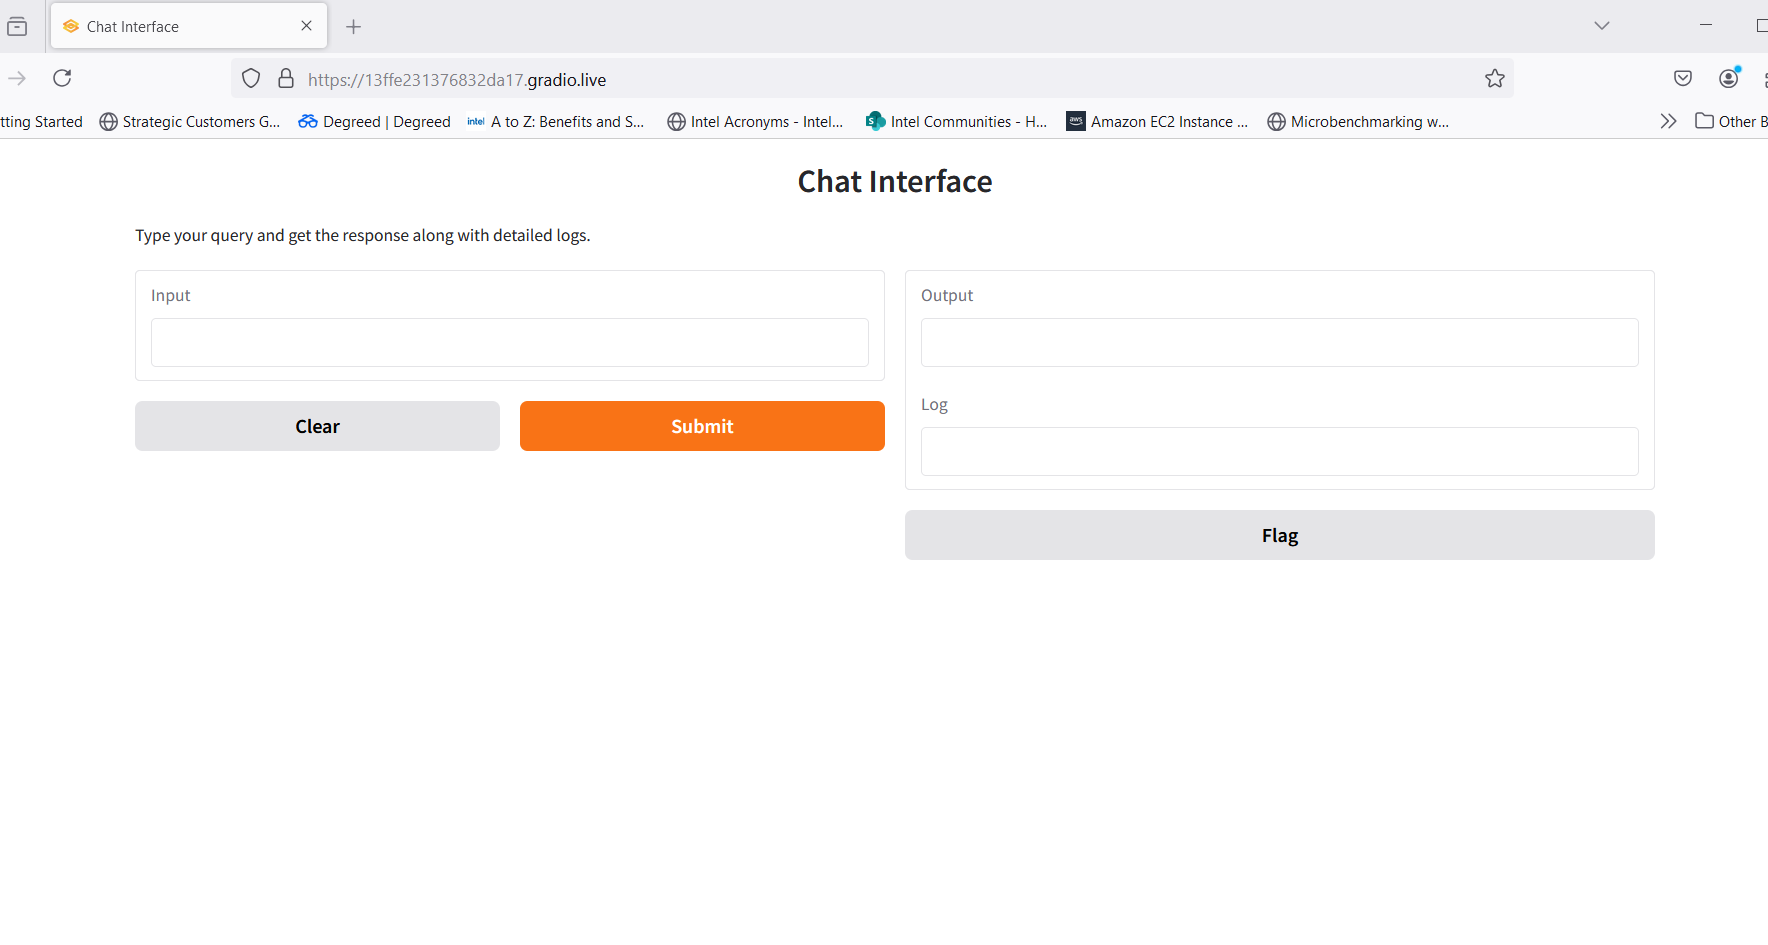